# Import Libraries


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import os
import random
from math import sqrt
random.seed(18)

from datetime import date
import datetime
import holidays
import calendar

from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

TRAINING = True
TEST_SIZE = 64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# First Analysis: next 100 days analysis (London - Barcelona)

## Import and prepare Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_Industry/60days.csv', delimiter=",") # import data

# get only min price per date and tracking date (sometimes there are more flights for the same day)
df = df.groupby(["Origin", "Destination", "Date", "Tracking Date"], as_index=False)["Price"].min() 
df = df.reset_index()

for index, row in df.iterrows():
    df.loc[index, "Date"] = row["Date"].replace(" ", "")
df = df.iloc[:, 1:]

In [ ]:
print(df)

   Origin Destination        Date Tracking Date   Price
0     STN         BCN  05/04/2022    05-04-2022   41.99
1     STN         BCN  05/05/2022    05-04-2022   52.49
2     STN         BCN  05/06/2022    05-04-2022  108.99
3     STN         BCN  05/07/2022    05-04-2022   44.99
4     STN         BCN  05/08/2022    05-04-2022   63.59
..    ...         ...         ...           ...     ...
89    STN         BCN  08/13/2022    05-04-2022   59.60
90    STN         BCN  08/15/2022    05-04-2022   49.99
91    STN         BCN  08/17/2022    05-04-2022   59.60
92    STN         BCN  08/23/2022    05-04-2022   42.49
93    STN         BCN  08/30/2022    05-04-2022   32.99

[94 rows x 5 columns]


## Plot Price x Day and mark weekend and holidays

In [ ]:
def check_if_holiday(date):
    uk_holidays = holidays.UnitedKingdom()
    it_holidays = holidays.Italy()
    es_holidays = holidays.Spain()
    fr_holidays = holidays.France()

    if date in it_holidays or date in es_holidays or date in fr_holidays or date in uk_holidays:
        return True
    else:
        return False

def get_holidays(df):
    holidays = []
    for index, row in df.iterrows():
        if check_if_holiday(row["Date"]):
            holidays.append(row["Date"])
    return holidays


def get_weekends(df):
    weekends = []
    for index, row in df.iterrows():
        if row["Datetime Date"].weekday() > 4:
            weekends.append(row["Date"])
    return weekends

def get_national_holidays(holiday, country):
    if country == "Italy":
        checker = holidays.Italy()
    if country == "Spain":
        checker = holidays.Spain()
    if country == "France":
        checker = holidays.France()
    if country == "UK":
        checker = holidays.UK()
    national_holidays = [h for h in holiday if h in checker]
    return national_holidays

def get_indexes(list_of_days, all_dates):
    indexes = []
    for d in list_of_days:
        if d in all_dates:
            index = all_dates.index(d)
            indexes.append(index)
    return indexes

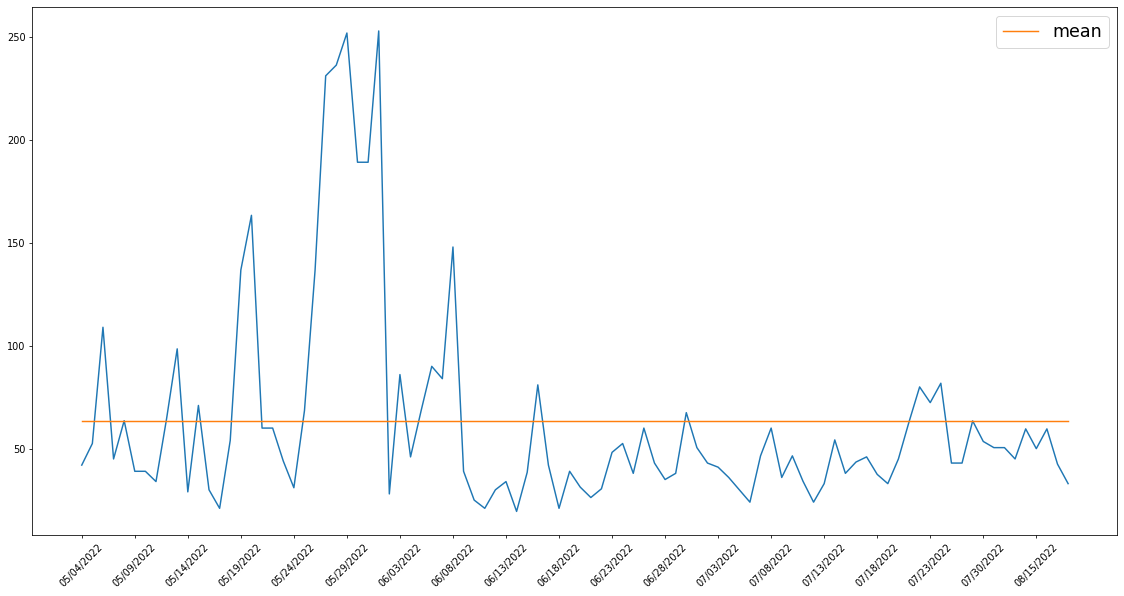

In [ ]:
df1 = df[df["Origin"] == "STN"]
df1 = df1[df1["Destination"] == "BCN"]
df1 = df1.reset_index()
df1 = df1.iloc[:, 2:]

x = []
y = []
means = []

for index, row in df.iterrows():
    x.append(row["Date"])
    y.append(row["Price"])
    means.append(round(df1["Price"].mean(), 2))

figure(figsize = (20, 10), dpi = 70)

plt.plot(x, y)
plt.plot(x, means, label="mean")

xt = [x[i] for i in range(0, len(x), 5)]
plt.xticks(xt, rotation = '45')

plt.legend(fontsize=18,loc='upper right')

plt.show()

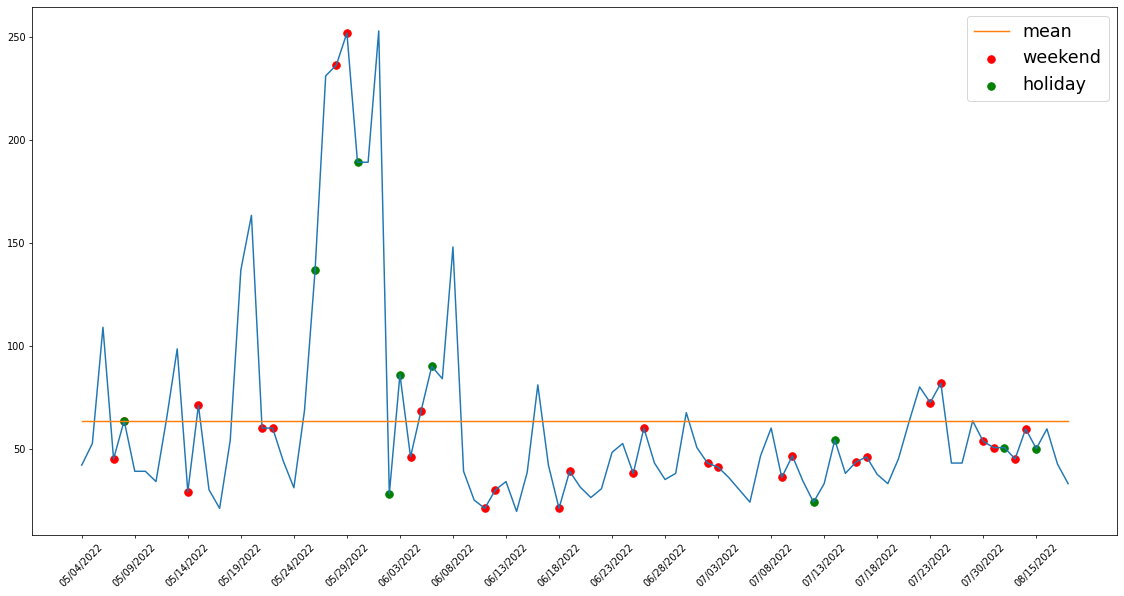

In [ ]:
format='%m/%d/%Y'
df1['Datetime Date'] = pd.to_datetime(df1['Date'], format=format)

weekend = get_weekends(df1)
indexes = get_indexes(weekend, x)

holiday = get_holidays(df1)
indexes_holi = get_indexes(holiday, x)

figure(figsize = (20, 10), dpi = 70)

plt.plot(x, y)
plt.plot(x, means, label="mean")

for i in range(len(indexes)-1):
    plt.scatter(weekend[i], y[indexes[i]], s=60, color = "red")
for i in range(len(indexes_holi)-1):
    plt.scatter(holiday[i], y[indexes_holi[i]], s=60, color = "green")

plt.scatter(weekend[len(indexes)-1], y[indexes[len(indexes)-1]], s=60, color = "red", label="weekend")
plt.scatter(holiday[len(indexes_holi)-1], y[indexes_holi[len(indexes_holi)-1]], s=60, color = "green", label="holiday")

xt = [x[i] for i in range(0, len(x), 5)]
plt.xticks(xt, rotation = '45')
plt.legend(fontsize=18,loc='upper right')

plt.show()

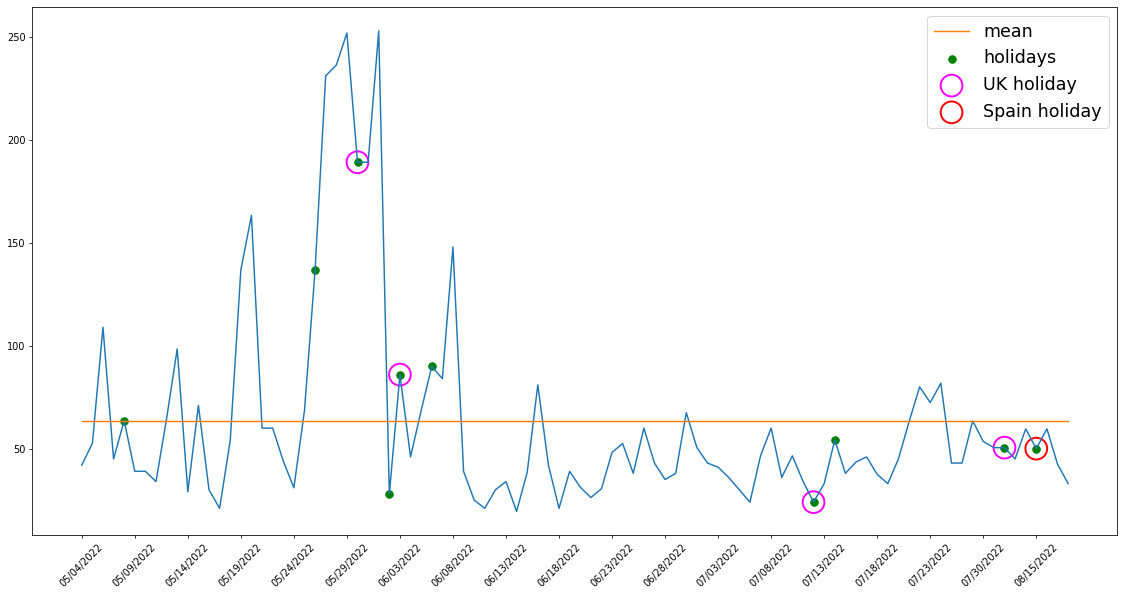

In [ ]:
UK_holidays = get_national_holidays(holiday, "UK")
spain_holidays = get_national_holidays(holiday, "Spain")

figure(figsize = (20, 10), dpi = 70)

plt.plot(x, y)
plt.plot(x, means, label="mean")

indexes_UK = get_indexes(UK_holidays, x)
indexes_spain = get_indexes(spain_holidays, x)

for i in range(len(indexes_holi)-1):
    plt.scatter(holiday[i], y[indexes_holi[i]], s=60, color = "green")

plt.scatter(holiday[len(indexes_holi)-1], y[indexes_holi[len(indexes_holi)-1]], s=60, color = "green", label="holidays")

for i in range(len(indexes_UK)-1):
    plt.scatter(UK_holidays[i], y[indexes_UK[i]], s=500,  facecolors = "none", edgecolors="magenta", linewidths=2)
for i in range(len(indexes_spain)-1):
    plt.scatter(spain_holidays[i], y[indexes_spain[i]], s=500,  facecolors = "none", edgecolors="red", linewidths=2)

plt.scatter(UK_holidays[len(indexes_UK)-1], y[indexes_UK[len(indexes_UK)-1]], s=500,  facecolors = "none", edgecolors="magenta", linewidths=2, label="UK holiday")
plt.scatter(spain_holidays[len(indexes_spain)-1], y[indexes_spain[len(indexes_spain)-1]], s=500,  facecolors = "none", edgecolors="red", linewidths=2, label="Spain holiday")

xt = [x[i] for i in range(0, len(x), 5)]
plt.xticks(xt, rotation = '45')
plt.legend(fontsize=18,loc='upper right')

plt.show()

# Second Analysis: Price variation with different tracking dates

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_Industry/dataset.csv', delimiter=",")
df = df.iloc[:,1:]

In [ ]:
print(df.head(10))

  Origin Destination        Date Tracking Date   Price
0    BCN         BLQ  04/24/2022    04-24-2022  146.99
1    BCN         BLQ  04/25/2022    04-24-2022  330.94
2    BCN         BLQ  04/26/2022    04-24-2022   93.99
3    BCN         BLQ  04/26/2022    04-26-2022  369.94
4    BCN         BLQ  04/27/2022    04-24-2022  286.94
5    BCN         BLQ  05/01/2022    04-24-2022  108.99
6    BCN         BLQ  05/01/2022    04-25-2022  108.99
7    BCN         BLQ  05/01/2022    04-26-2022  137.39
8    BCN         BLQ  05/01/2022    04-27-2022  146.99
9    BCN         BLQ  05/01/2022    04-28-2022  170.99


Compute the mean for each air route on different tracking dates. We consider 10 days of may (15-24). We compute the mean of the prices for every day on each tracking date.

In [ ]:
relevations = []
dates = ['05/24/2022', '05/26/2022', '05/30/2022']

for d in dates:
    tmp = []
    for i in range(14):
        dfi = df[df["Origin"] == "STN"]
        dfi = dfi[dfi["Destination"] == "BCN"]
        tracking_day = (i + 1)
        if tracking_day < 10:
            date = '05-' + '0' + str(tracking_day) + '-2022'
        else:
            date = '05-' + str(tracking_day) + '-2022'
        dfi = dfi[dfi["Tracking Date"] == date]
        dfi = dfi[dfi["Date"] == d]
        tmp.append((date, dfi["Price"].iloc[0], d))
    relevations.append(tmp)

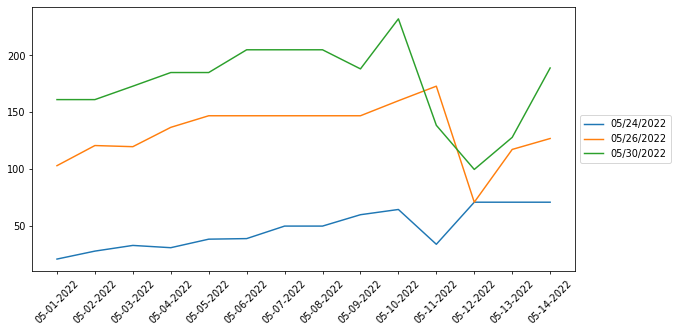

In [ ]:
figure(figsize = (10, 5), dpi = 70)

for i in range(3):
    x = []
    y = []
    for el in relevations[i]:
        x.append(el[0])
        y.append(el[1])
    plt.plot(x, y, label = el[2])

plt.xticks(rotation='45')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

It is important the day of the flight and how distant we are from that day. It is not too important the week day corresponding to the tracking date

# Data preparation, training and evaluation

## Pre-Processing

In [ ]:
def get_days_near_holiday(holiday):
    near_holiday = []
    for h in holiday:
        date = (pd.to_datetime(h, format ='%m/%d/%Y')-datetime.timedelta(days=1)).strftime(format ='%m/%d/%Y')
        near_holiday.append(date)
        date = (pd.to_datetime(h, format ='%m/%d/%Y')+datetime.timedelta(days=1)).strftime(format ='%m/%d/%Y')
        near_holiday.append(date)
    return near_holiday

def convert_onehot(column_name, df):
    one_hot = pd.get_dummies(df[column_name])
    df = df.drop(column_name, axis=1)
    df = df.join(one_hot)
    return df

def normalize_column(df, column_name, min_value, max_value):
    df[column_name] = df[column_name].apply(lambda x: ((x-min_value)/(max_value-min_value)))
    return df

def denormalize_column(x, min_value, max_value):
    x = x*(max_value-min_value)+min_value
    return x

In [ ]:
days_left = []
week_day = []

holiday = get_holidays(df)
holiday = set(holiday)
holiday = list(holiday)
near_holiday = get_days_near_holiday(holiday)
holiday = holiday + near_holiday

for index, row in df.iterrows():
    dt = pd.to_datetime(row['Date'], format='%m/%d/%Y')
    dt1 = pd.to_datetime(row['Tracking Date'], format='%m-%d-%Y')
    week_day.append(calendar.day_name[dt.weekday()])
    days_left.append((dt-dt1).days)

near_holiday = []
for index, row in df.iterrows():
    if row["Date"] in holiday:
        near_holiday.append(1)
    else:
        near_holiday.append(0)

df["Near Holiday"] = near_holiday
df['Week Day'] = week_day
df['Days Left'] = days_left

df = convert_onehot("Origin", df)
df.rename(columns = {'BCN':'BCN-origin', 'BVA':'BVA-origin', 'STN':'STN-origin', "BLQ":'BLQ-origin'}, inplace = True)

df = convert_onehot('Week Day', df)

df = convert_onehot("Destination", df)
df.rename(columns = {'BCN':'BCN-destination', 'BVA':'BVA-destination', 'STN':'STN-destination', "BLQ":'BLQ-destination'}, inplace = True)
df.head(5)

,Date,Tracking Date,Price,Near Holiday,Days Left,BCN-origin,BLQ-origin,BVA-origin,STN-origin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BCN-destination,BLQ-destination,BVA-destination,STN-destination
0,04/24/2022,04-24-2022,146.99,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,04/25/2022,04-24-2022,330.94,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,04/26/2022,04-24-2022,93.99,1,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,04/26/2022,04-26-2022,369.94,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,04/27/2022,04-24-2022,286.94,0,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
# Select target and predictor column
target = ['Price']
predictors = [col for col in df.columns if col not in ["Price", "Date", "Tracking Date"]]

# Normalize Days Left column
max_days = df["Days Left"].max()
min_days = df["Days Left"].min()
df = normalize_column(df, "Days Left", min_days, max_days)

In [ ]:
paths = [("STN", "BCN"), ("BCN", "STN"), ("STN", "BLQ"), ("BLQ", "STN"), ("BLQ", "BCN"), 
            ("BCN", "BLQ"), ("BVA", "BLQ"), ("BLQ", "BVA"), ("BVA", "BCN"), ("BCN", "BVA")]

In [ ]:
dates = ["05/" + str(i) + "/2022" for i in range(8,23)]
tracking_dates_april = ["04-" + str(i) + "-2022" for i in range(24, 31)]
tracking_dates_may = ["05-0" + str(i) + "-2022" for i in range(1,9)]
tracking_dates = tracking_dates_april + tracking_dates_may

count = 0
already_insered = []
insered = []
while(count < TEST_SIZE):
    date_index = random.randint(0, len(dates)-1)
    path_index = random.randint(0, len(paths)-1)
    origin = paths[path_index][0]+"-origin"
    destination = paths[path_index][1]+"-destination"
    date_path = (date_index, path_index)
    if date_path not in already_insered:
        already_insered.append(date_path)
        dfi = df[df["Date"]==dates[date_index]]
        dfi = dfi[dfi["Tracking Date"].between(tracking_dates[date_index],dates[date_index],inclusive="left")]
        dfi = dfi[dfi[origin] == 1]
        dfi = dfi[dfi[destination] == 1]
        if dfi.shape[0] == 14:
            insered.append(date_path)
            if count == 0:
                df_check = dfi
            else:
                df_check = pd.concat([df_check, dfi])
            count += 1

In [ ]:
# Remove check from dataframe, will add its data manually to train and test
df = pd.concat([df,df_check]).drop_duplicates(keep=False)

In [ ]:
# Normalize Price column (train)
max_price = df["Price"].max()
min_price = df["Price"].min()
df = normalize_column(df, "Price", min_price, max_price)

In [ ]:
# Create X and y
X = df[predictors].values
y = df[target].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42)
 
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7393, 17)
(7393, 1)
(1009, 17)
(1009, 1)


In [ ]:
# Normalize Price column (test)
df_check = normalize_column(df_check, "Price", min_price, max_price)
X_test = df_check[predictors].values
y_test = df_check[target].values

## Training

### Neural Network Model

Epoch 1/300
450/463 [============================>.] - ETA: 0s - loss: 0.0374
Epoch 1: saving model to /content/drive/MyDrive/AI_Industry/cp.ckpt
463/463 [==============================] - 3s 3ms/step - loss: 0.0373 - val_loss: 0.0297
Epoch 2/300
445/463 [===========================>..] - ETA: 0s - loss: 0.0295
Epoch 2: saving model to /content/drive/MyDrive/AI_Industry/cp.ckpt
463/463 [==============================] - 1s 3ms/step - loss: 0.0297 - val_loss: 0.0278
Epoch 3/300
449/463 [============================>.] - ETA: 0s - loss: 0.0273
Epoch 3: saving model to /content/drive/MyDrive/AI_Industry/cp.ckpt
463/463 [==============================] - 1s 3ms/step - loss: 0.0274 - val_loss: 0.0261
Epoch 4/300
461/463 [============================>.] - ETA: 0s - loss: 0.0261
Epoch 4: saving model to /content/drive/MyDrive/AI_Industry/cp.ckpt
463/463 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 5/300
446/463 [===========================>..] - ETA: 

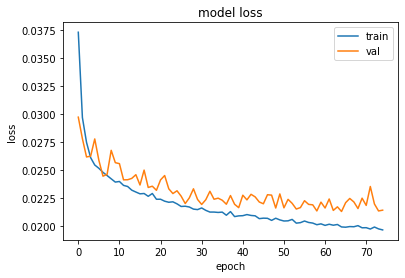

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_Industry/cp.ckpt"

if TRAINING:
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)

    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)

    # create ANN model
    nn1 = Sequential()
    
    nn1.add(Dense(units=16, input_dim=17, kernel_initializer='normal', activation='relu'))
    nn1.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    nn1.add(Dense(units=64, kernel_initializer='normal', activation='relu')) 
    nn1.add(Dense(units=32, kernel_initializer='normal', activation='relu')) 
    nn1.add(Dense(1, kernel_initializer='normal'))
    
    # Compiling the model"
    nn1.compile(loss='mean_squared_error', optimizer="adam")
    
    # Fitting the ANN to the Training set
    history = nn1.fit(X_train, y_train ,batch_size = 16, validation_data=(X_val, y_val), epochs = 300, verbose=1,  callbacks=[callback, cp_callback])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

else:
    nn1 = Sequential()
    
    nn1.add(Dense(units=16, input_dim=17, kernel_initializer='normal', activation='relu'))
    nn1.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    nn1.add(Dense(units=64, kernel_initializer='normal', activation='relu')) 
    nn1.add(Dense(units=32, kernel_initializer='normal', activation='relu')) 
    nn1.add(Dense(1, kernel_initializer='normal'))
    
    nn1.load_weights(checkpoint_path)

### Random Forest

In [ ]:
## Define Grid 
y_train = y_train.ravel()

grid = { 
    'n_estimators': [200,300,400,500],
    'max_depth' : [5, 10,  15, 20],
}

## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
# capire che metrica usa gridsearch
CV_rfr.fit(X_train, y_train)
print(CV_rfr.best_estimator_)
print(CV_rfr.best_params_)

RandomForestRegressor(max_depth=10, n_estimators=300)
{'max_depth': 10, 'n_estimators': 300}


In [ ]:
rf = RandomForestRegressor(**CV_rfr.best_params_).fit(X_train, y_train)

### Bagging

In [ ]:
## Define Grid 
grid = { 
    'n_estimators': [10, 20, 50, 70, 100],
}

## Grid Search function
CV_bg = GridSearchCV(estimator=BaggingRegressor(), param_grid=grid, cv= 5)
CV_bg.fit(X_train, y_train)
print(CV_bg.best_estimator_)
print(CV_bg.best_params_)

BaggingRegressor(n_estimators=70)
{'n_estimators': 70}


In [ ]:
bg = BaggingRegressor(**CV_bg.best_params_).fit(X_train, y_train)

### Gradient Boosting

In [ ]:
## Define Grid 
grid = { 
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150, 200, 300, 400]
}

## Grid Search function
CV_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=grid, cv= 5)
CV_gb.fit(X_train, y_train)
print(CV_gb.best_estimator_)
print(CV_gb.best_params_)

GradientBoostingRegressor(n_estimators=400)
{'learning_rate': 0.1, 'n_estimators': 400}


In [ ]:
gb = GradientBoostingRegressor(**CV_gb.best_params_).fit(X_train, y_train)

### SVM

In [ ]:
## Define Grid 
grid = { 
    'kernel': ["rbf", "poly"],
    'degree': [3, 4, 5, 6]
}

## Grid Search function
CV_svm = GridSearchCV(estimator=SVR(), param_grid=grid, cv= 5)
CV_svm.fit(X_train, y_train)
print(CV_svm.best_estimator_)
print(CV_svm.best_params_)

SVR(degree=5, kernel='poly')
{'degree': 5, 'kernel': 'poly'}


In [ ]:
svm = SVR(**CV_svm.best_params_).fit(X_train, y_train)

### KNN

In [ ]:
## Define Grid 
grid = { 
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
}

## Grid Search function
CV_knn = GridSearchCV(estimator=neighbors.KNeighborsRegressor(), param_grid=grid, cv= 5)
CV_knn.fit(X_train, y_train)
print(CV_knn.best_estimator_)
print(CV_knn.best_params_)

KNeighborsRegressor(n_neighbors=7)
{'n_neighbors': 7}


In [ ]:
knn = neighbors.KNeighborsRegressor(**CV_knn.best_params_).fit(X_train, y_train)

### KNN Ablation

In [ ]:
n_neighbors = [2, 4, 6, 7]
knn_models = []
for i in n_neighbors:
    model = neighbors.KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
    knn_models.append((str(i) + " Neighbors", model))

# Evaluation

## MSE Evaluation

In [ ]:
models = [("NN Normal", nn1), ("Random Forest", rf), ("Bagging", bg), ("Gradient Boosting", gb), ("KNN", knn), ("SVM", svm)]

In [ ]:
def models_predict(models, X):
    predictions = []
    for m in models:
        pred = m[1].predict(X)
        predictions.append((m[0], pred))
    return predictions

def mse_evaluation(y_test, predictions):
    for p in predictions:
        mse = mean_squared_error(y_test, p[1])
        print(p[0] + " MSE: ", mse)

def denormalize_predictions(predictions):
    denorm_predictions = []
    for p in predictions:
        denormalized = list(denormalize_column(p[1], min_price, max_price))
        denorm_predictions.append((p[0], denormalized))
    return denorm_predictions

In [ ]:
predictions = models_predict(models, X_test)

In [ ]:
mse_evaluation(y_test, predictions)

NN Normal MSE:  0.057195981414772015
Random Forest MSE:  0.04178864802879718
Bagging MSE:  0.05979495757412611
Gradient Boosting MSE:  0.035760108869904585
KNN MSE:  0.06640887735117809
SVM MSE:  0.054475499842516935


In [ ]:
## KNN MODELS
predictions = models_predict(knn_models, X_test)
mse_evaluation(y_test, predictions)

2 Neighbors MSE:  0.07579949957394612
4 Neighbors MSE:  0.0707116945638575
6 Neighbors MSE:  0.0680169730290433
7 Neighbors MSE:  0.06640887735117809


## Check Behaviour for a date and a route

In [ ]:
def get_train_test_for_path_date(date, path, df_check_test, predictors, models):
    check_test = df_check_test[df_check_test["Date"] == date]
    check_test = check_test[check_test[path[0]+"-origin"] == 1]
    check_test = check_test[check_test[path[1]+"-destination"] == 1]

    X_test = check_test[predictors].values
    predictions = models_predict(models, X_test)

    prices_test = check_test["Price"].tolist()
    return prices_test, predictions

In [ ]:
ind = insered[random.randrange(0, len(insered))]
d = dates[ind[0]]
p = paths[ind[1]]
print("Date:", d)
print("Path:", p)
y_true, predictions = get_train_test_for_path_date(d, p, df_check, predictors, models)
denorm_predictions = denormalize_predictions(predictions)
y_true = [i*(max_price-min_price)+min_price for i in y_true]

Date: 05/13/2022
Path: ('BLQ', 'BVA')


In [ ]:
len_test = len(predictions[0][1])
len_train = len(y_true) - len_test

[Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

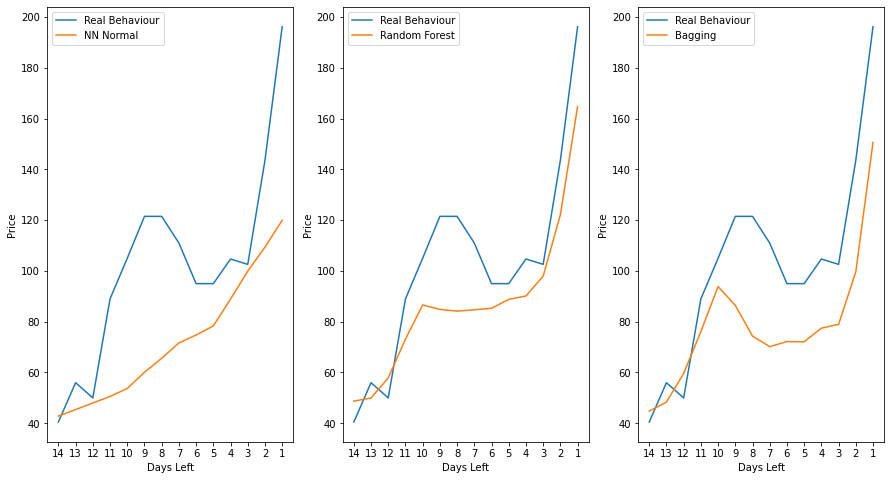

In [ ]:
x = range(1, len(y_true)+1)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 8))
ax1.plot(x, y_true, label = "Real Behaviour")
ax1.plot(x, denorm_predictions[0][1], label = predictions[0][0])
ax1.legend(loc = 'upper left')
ax1.set_xlabel('Days Left')
ax1.set_ylabel('Price')
ax1.set_xticks(x)
ax1.set_xticklabels(x[::-1])
ax2.plot(x, y_true,  label = "Real Behaviour")
ax2.plot(x, denorm_predictions[1][1], label = predictions[1][0])
ax2.legend(loc = 'upper left')
ax2.set_xlabel('Days Left')
ax2.set_ylabel('Price')
ax2.set_xticks(x)
ax2.set_xticklabels(x[::-1])
ax3.plot(x, y_true, label = "Real Behaviour")
ax3.plot(x, denorm_predictions[2][1], label = predictions[2][0])
ax3.legend(loc = 'upper left')
ax3.set_xlabel('Days Left')
ax3.set_ylabel('Price')
ax3.set_xticks(x)
ax3.set_xticklabels(x[::-1])


[Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

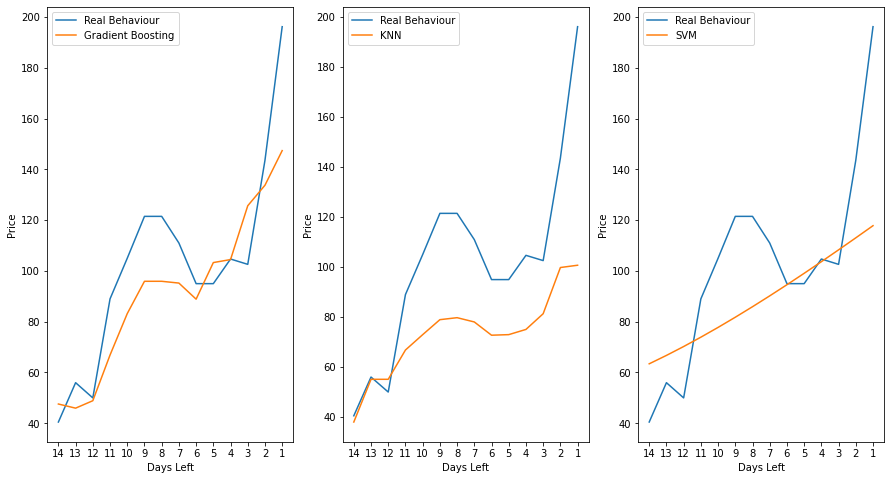

In [ ]:
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (15, 8))
ax4.plot(x, y_true, label = "Real Behaviour")
ax4.plot(x, denorm_predictions[3][1], label = predictions[3][0])
ax4.legend(loc = 'upper left')
ax4.set_xlabel('Days Left')
ax4.set_ylabel('Price')
ax4.set_xticks(x)
ax4.set_xticklabels(x[::-1])
ax5.plot(x, y_true, label = "Real Behaviour")
ax5.plot(x, denorm_predictions[4][1], label = predictions[4][0])
ax5.legend(loc = 'upper left')
ax5.set_xlabel('Days Left')
ax5.set_ylabel('Price')
ax5.set_xticks(x)
ax5.set_xticklabels(x[::-1])
ax6.plot(x, y_true, label = "Real Behaviour")
ax6.plot(x, denorm_predictions[5][1], label = predictions[5][0])
ax6.legend(loc = 'upper left')
ax6.set_xlabel('Days Left')
ax6.set_ylabel('Price')
ax6.set_xticks(x)
ax6.set_xticklabels(x[::-1])

In [ ]:
y_tot, predictions = get_train_test_for_path_date(d, p, df_check, predictors, knn_models)
denorm_predictions = denormalize_predictions(predictions)

[Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

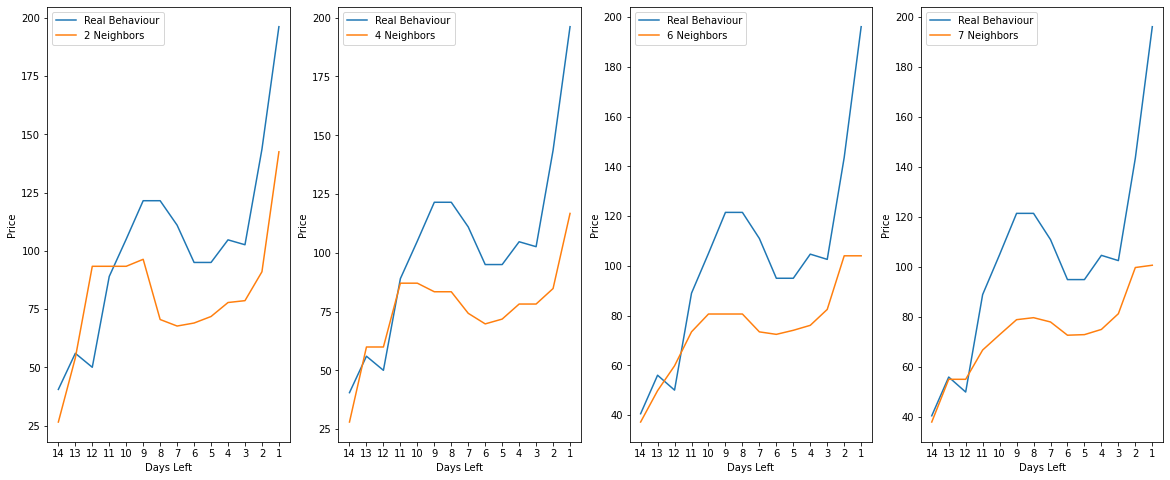

In [ ]:
x = range(1, len(y_tot)+1)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(1,4, figsize = (20, 8))
ax1.plot(x, y_true, label = "Real Behaviour")
ax1.plot(x, denorm_predictions[0][1], label = predictions[0][0])
ax1.legend(loc = 'upper left')
ax1.set_xlabel('Days Left')
ax1.set_ylabel('Price')
ax1.set_xticks(x)
ax1.set_xticklabels(x[::-1])
ax2.plot(x, y_true,  label = "Real Behaviour")
ax2.plot(x, denorm_predictions[1][1], label = predictions[1][0])
ax2.legend(loc = 'upper left')
ax2.set_xlabel('Days Left')
ax2.set_ylabel('Price')
ax2.set_xticks(x)
ax2.set_xticklabels(x[::-1])
ax3.plot(x, y_true, label = "Real Behaviour")
ax3.plot(x, denorm_predictions[2][1], label = predictions[2][0])
ax3.legend(loc = 'upper left')
ax3.set_xlabel('Days Left')
ax3.set_ylabel('Price')
ax3.set_xticks(x)
ax3.set_xticklabels(x[::-1])
ax4.plot(x, y_true, label = "Real Behaviour")
ax4.plot(x, denorm_predictions[3][1], label = predictions[3][0])
ax4.legend(loc = 'upper left')
ax4.set_xlabel('Days Left')
ax4.set_ylabel('Price')
ax4.set_xticks(x)
ax4.set_xticklabels(x[::-1])

## BIB - DIP: Metrics Implementations & Models Evaluation

In [ ]:
def delta_days(pred, gt):
    right = []
    count_true = 0
    count_false = 0
    for i in range(len(gt)-1):
        if (pred[i+1] >= pred[i] and gt[i+1] >= gt[i]) or (pred[i+1] < pred[i] and gt[i+1] < gt[i]):
            right.append(True)
            count_true += 1
        else:
            right.append(False)
            count_false += 1
    percentage_true = count_true / (count_true + count_false)    
    return right, percentage_true
    
def delta_price(pred, gt):
    delta=0
    min_pred = min(pred)
    pred_index = list(pred).index(min_pred)
    min_gt = min(gt)
    gt_index = list(gt).index(min_gt)


    if pred_index != gt_index:
        delta = gt[pred_index] - min_gt
    return delta

def compute_means(models, dates, paths, df_check, predictors, insered):
    percentages = []
    deltas = []
    for i in range(len(models)):
        percentages.append([])
        deltas.append([])

    for flights in insered:
        d = dates[flights[0]]
        p = paths[flights[1]]
        y_true, predictions = get_train_test_for_path_date(d, p, df_check, predictors, models)
        denorm_predictions = denormalize_predictions(predictions)
        y_true = [i*(max_price-min_price)+min_price for i in y_true]
        for i in range(len(models)): 
            pred = denorm_predictions[i][1]  
            _, percentage_true = delta_days(pred, y_true)
            percentages[i].append(percentage_true)
            delta = delta_price(pred, y_true)
            deltas[i].append(delta)

    mean_percentage = [sum(p)/len(p) for p in percentages]
    mean_deltas = [sum(d)/len(d) for d in deltas]

    print('MeanBIB Results')
    for i in range(len(mean_percentage)):
        print(models[i][0], mean_percentage[i])
    print()
    print('MeanDP Results')
    for i in range(len(mean_deltas)):
        print(models[i][0], mean_deltas[i])
    print()

compute_means(models, dates, paths, df_check, predictors, insered)
print("\nKNN Ablation")
compute_means(knn_models, dates, paths, df_check, predictors, insered)

MeanBIB Results
NN Normal 0.6959134615384617
Random Forest 0.6298076923076924
Bagging 0.5937500000000002
Gradient Boosting 0.6790865384615387
KNN 0.7127403846153846
SVM 0.7716346153846155

MeanDP Results
NN Normal 22.788125000000008
Random Forest 12.918906250000001
Bagging 16.891875000000002
Gradient Boosting 9.644843749999998
KNN 26.934687500000006
SVM 20.078750000000003


KNN Ablation
MeanBIB Results
2 Neighbors 0.6947115384615385
4 Neighbors 0.6935096153846154
6 Neighbors 0.6802884615384617
7 Neighbors 0.7127403846153846

MeanDP Results
2 Neighbors 17.722500000000004
4 Neighbors 15.420625
6 Neighbors 17.493437500000002
7 Neighbors 26.934687500000006



# Get Behaviour

In [ ]:
def generate_x_from_date(date, origin=None, destination=None):
    week_day = []
    days_left = []
    holiday = []
    airports = ["BCN", "BLQ", "BVA", "STN"]
    if origin not in airports:
        raise ValueError("Cannot provide predictions for the origin selected")
    if destination not in airports:
        raise ValueError("Cannot provide predictions for the destination selected")  
    date = pd.to_datetime(date, format ='%m/%d/%Y')
    today = datetime.datetime.now()
    difference = date - today
    days = difference.days

    if days >= 31:
        raise ValueError("Too distant date, come back later")  

    for i in range(days+2):
            date = (today + datetime.timedelta(days=i))
            week_day.append(calendar.day_name[date.weekday()])
            days_left.append(i)
            date = date.strftime(format ='%m/%d/%Y')
            if check_if_holiday(date):
                holiday.append(date)
    near_holiday = get_days_near_holiday(holiday)
    holiday = holiday + near_holiday

    near_holiday = []
    for i in range(days+2):
        date = (today + datetime.timedelta(days=i)).strftime(format ='%m/%d/%Y')
        if date in holiday:
            near_holiday.append(1)
        else:
            near_holiday.append(0)

    df = pd.DataFrame(week_day, columns = ['Week Day'])
    df = convert_onehot('Week Day', df)
    df["Days Left"] = days_left
    df["Near Holiday"] = near_holiday

    if origin!=None and destination!=None:
        origins = [origin for i in range(len(week_day))]
        destinations = [destination for i in range(len(week_day))]

        df["Origin"]= origins
        df["Destination"] = destinations

        df = convert_onehot("Origin", df)
        df.rename(columns = {'BCN':'BCN-origin', 'BVA':'BVA-origin', 'STN':'STN-origin', "BLQ":'BLQ-origin'}, inplace = True)

        df = convert_onehot("Destination", df)
        df.rename(columns = {'BCN':'BCN-destination', 'BVA':'BVA-destination', 'STN':'STN-destination', "BLQ":'BLQ-destination'}, inplace = True)

    zeros = []
    for i in range(len(week_day)):
        zeros.append(0)
    
    for air in airports:
        if air != origin:
            name = air+"-origin"
            df[name] = zeros
        if air != destination:
            name = air+"-destination"
            df[name] = zeros

    return df

dfg = generate_x_from_date("06/17/2022", "BLQ", "BCN")

columns = df.columns.values.tolist()
to_remove = ['Date', 'Tracking Date', 'Price']
pred_columns = [c for c in columns if c not in to_remove]

dfg = normalize_column(dfg, "Days Left", min_days, max_days)
X = dfg[pred_columns].values


In [ ]:
predictions = models_predict(models, X)
denorm_predictions = denormalize_predictions(predictions)

Flight from Bologna to Barcelona, Date: 06/16/2022


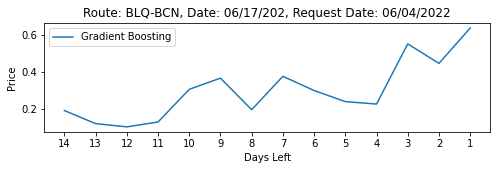

In [ ]:
x1 = range(len(X), 0, -1)
x2 = range(len(X)+2)

print("Flight from Bologna to Barcelona, Date: 06/16/2022")

fig, ax = plt.subplots(1,1, figsize = (8, 2))
ax.title.set_text("Route: BLQ-BCN, Date: 06/17/202, Request Date: 06/04/2022")
ax.set_xlabel('Days Left')
ax.set_ylabel('Price')
ax.set_xticks(x2)
ax.set_xticklabels(x2[::-1])
ax.plot(x1, predictions[3][1],  label = predictions[3][0])
ax.legend(loc = 'upper left')